# XGBoost
* model is built using raw XGBoost functions - requires DMatrix format (preprocessing step)
* another method in building XGBoost is to use sklearn wrapper - utilizes pandas dataframes as inputs

## Advantange
1. Regularization
    * standard GBM (Gradient Boosting) has no regularization
    * XGboost has regularization
    * regularization tries to push coefficients of function to zero thus reducing cost term 
2. Parallel Processing
    * much faster than GBM
    * can use multiple cores to make tree
3. High Flexibility
    * custom opitmization objectives and evaluation criteria
4. Handling Missing Values
    * built in routine to handle missing values
    * user required to supply different value than other obersvations and pass this as a parameter
    * XGBoost tries different things as it encounters missing values on each node and learns which path to take for missing values
5. Tree Pruning
    * splits are made upto max_depth and pruning begins where splits are removed that have no positive gain
6. Built-in Cross-Validation
    * cross-validation at each iteration of boosting process 
    * thus is possible to get exact optimum number of boosting iterations in a single run
7. Continue on Exisiting Model

# Objective

Utlizing a ML classifiers to predict if a customer responds to a banks advertising or insurance rate offers. End goal is to boost banks bottom line and to increase customers financial activity in the bank.

# Features
* customer_id - an anonymous id unique to a given customer
* Balance : - Current + Savings Account Balance
* PreviousCampaignResult - Last Campaign Results
* Product1...Product6 - List of different products owned by the customer
* Transaction1...Transaction9 - Last 9 transactions made by the customer
* External Accounts 1...External Accounts 7 - * External accounts held by the customer, including bills
* Activity Indicator - Number of activities done the customer, including telebanking, going to the bank
* Regular Interaction Indicator - How frequent the customer is interacting with the bank (Rating Scale)
* CompetitiveRate1 ... CompetitiveRate7 - Interest rates offered to the customer
* RateBefore - Interest rates on the products, customer have before the competitive rates being offered
* ReferenceRate -Interest rates on the products, the customer have after the negotiations made to the competitive rates being offered

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import \
GridSearchCV, \
train_test_split

from sklearn.metrics import \
auc, \
roc_auc_score, \
accuracy_score, \
roc_curve, \
confusion_matrix, \
precision_score, \
recall_score, \
f1_score, \
precision_recall_curve

from sklearn.preprocessing import StandardScaler

In [3]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

In [4]:
print(f'df_train shape: {df_train.shape}')
print(f'df_test shape: {df_test.shape}')

df_train shape: (63999, 37)
df_test shape: (1480, 36)


In [5]:
df_train = df_train.drop('Customer_id', axis = 1)

In [6]:
print(f'df_train shape: {df_train.shape}')
print(f'df_test shape: {df_test.shape}')

df_train shape: (63999, 36)
df_test shape: (1480, 36)


In [7]:
# identify target, predicator, categorical, and continous variables 
# for pipeline transformations

Target = 'Target'

col_predictors = [col for col in df_train.columns if col not in [Target]]

print(f'TARGET: {Target} \n')
print(f'columns predictors: {col_predictors} \n')

TARGET: Target 

columns predictors: ['Balance', 'PreviousCampaignResult', 'Product1', 'Product2', 'Product3', 'Product4', 'Product5', 'Product6', 'Transaction1', 'Transaction2', 'Transaction3', 'Transaction4', 'Transaction5', 'Transaction6', 'Transaction7', 'Transaction8', 'Transaction9', 'ExternalAccount1', 'ExternalAccount2', 'ExternalAccount3', 'ExternalAccount4', 'ExternalAccount5', 'ExternalAccount6', 'ExternalAccount7', 'ActivityIndicator', 'RegularInteractionIndicator', 'CompetitiveRate1', 'CompetitiveRate2', 'CompetitiveRate3', 'CompetitiveRate4', 'CompetitiveRate5', 'CompetitiveRate6', 'CompetitiveRate7', 'RateBefore', 'ReferenceRate'] 



In [8]:
X = df_train[col_predictors]
y = df_train['Target']

In [9]:
import xgboost as xgb
from xgboost import XGBClassifier

In [10]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = 'Precision')
    plt.plot(thresholds, recalls[:-1], "g-", label = 'Recall')
    plt.ylabel('Precision & Recall Scores')
    plt.xlabel('Thresholh')
    plt.legend(loc = 'best')
    plt.ylim([0, 1])
    plt.grid(True)

In [11]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recall Scores')
    plt.ylabel('Precision Scores')
    plt.axis([0, 1, 0, 1])

In [12]:
def modelfit(model, dtrain, dtest, predictors, useTrainCV = True, cv_folds = 5, early_stopping_rounds = 50):
    
    if useTrainCV:
        
        # get params being passed to model
        xgb_param = model.get_xgb_params()
        
        # load training data that is readable for XGBoost
        xgtrain = xgb.DMatrix(
            dtrain[predictors].values, 
            label = dtrain[Target].values,
            feature_names = predictors      # important - to get the feature names for plotting
        )
        
        
        # load testing (unseen) data that is readable for XGBoost
        xgtest = xgb.DMatrix(
            dtest[predictors].values
        )
        
        # use built-in cv to find optimum number of tress for current learning rate
        # num of trees = n_estimators
        cvresult = xgb.cv(
            xgb_param, 
            xgtrain, 
            num_boost_round = model.get_params()['n_estimators'], 
            nfold = cv_folds,
            metrics = 'auc', 
            early_stopping_rounds = early_stopping_rounds       # to find optimal num of boosting rounds
        )
        
        # set model num of trees to whatever xgboost.cv() found
        model.set_params(n_estimators = cvresult.shape[0])
    
    # Fit the algorithm on the data
    model.fit(dtrain[predictors], dtrain[Target], eval_metric = 'auc')
        
    # Predict training set:
    dtrain_predictions = model.predict(dtrain[predictors])            # actual 0 or 1 results
    dtrain_predprob = model.predict_proba(dtrain[predictors])[:,1]    # get probability predictions
    
    # Predict testing set:
    dtest_predictions = model.predict(dtest[predictors])
        
    # Print model report:
    print('\nModel Report')
    print('Accuracy : %.4g' % accuracy_score(dtrain[Target].values, dtrain_predictions))
    print('AUC Score (Train) : %f' % roc_auc_score(dtrain[Target], dtrain_predprob))
    print('Precision Score : %f' % precision_score(dtrain[Target], dtrain_predictions))
    print('Recall Score : %f' % recall_score(dtrain[Target], dtrain_predictions))
    print('F1 Score : %f' % f1_score(dtrain[Target], dtrain_predictions))
    
    # get fpr and tpr values for roc curve
    fpr, tpr, thresholds = roc_curve(dtrain[Target], dtrain_predprob)
    
    # get auc score
    auc_score = auc(fpr, tpr)
    
    #Plot the Roc Curve
    plt.plot(
        fpr, 
        tpr,
        linewidth = 2, 
        label = 'AUC = {:.4f}'.format(auc_score)
    )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize = 10)
    plt.ylabel('True Positive Rate', fontsize = 10)
    plt.title('XGBoost ROC Curve', fontsize = 15)
    plt.legend(loc = 'lower right', fontsize = 10)
    plt.show()
    
    # get values for Precision Recall Curve
    precisions, recalls, thresholds = precision_recall_curve(dtrain[Target], dtrain_predprob)
    
    # Plot Precision - Recall Curve
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    plt.show()
    
    plot_precision_vs_recall(precisions, recalls)
    plt.show()

    
    # feature importance plot
    
    # data for plot
    feat_imp = pd.Series(
        model.feature_importances_,        # y_values
        model.get_booster().feature_names  # x_values
    ).sort_values(ascending=False)         # descending order
    
    # make the bar-plot
    feat_imp.plot(
        kind = 'bar',
        figsize = (20, 10),
        fontsize = 20
    )
    
    # plot attributes
    plt.ylabel('Feature Importance Score', fontsize = 25)
    plt.xlabel('Features', fontsize = 25)
    plt.title('Feature Importances', fontsize = 30)
    plt.show()

    return dtest_predictions

## Initial Run

In [13]:
xgb_clf_1 = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 1000,
    max_depth = 5,
    min_child_weight = 1,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',   # loss function to minimize (log for binary)
    nthread = 4,
    scale_pos_weight = 1,
    seed = 27
)

C:\Users\Mah Lau\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Model Report
Accuracy : 0.6437
AUC Score (Train) : 0.697012
Precision Score : 0.653526
Recall Score : 0.611068
F1 Score : 0.631584


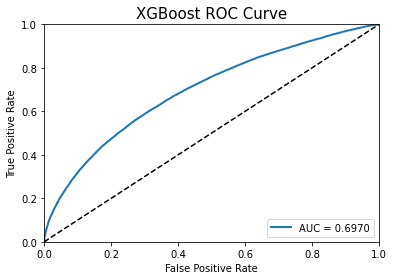

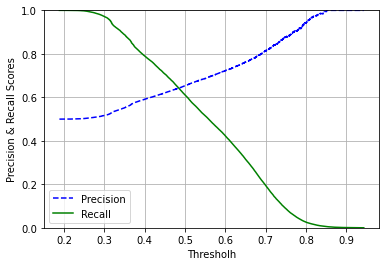

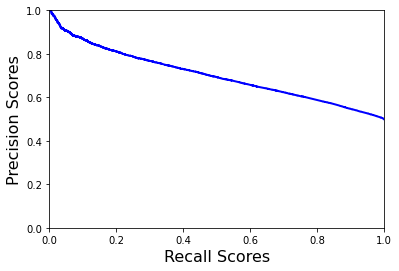

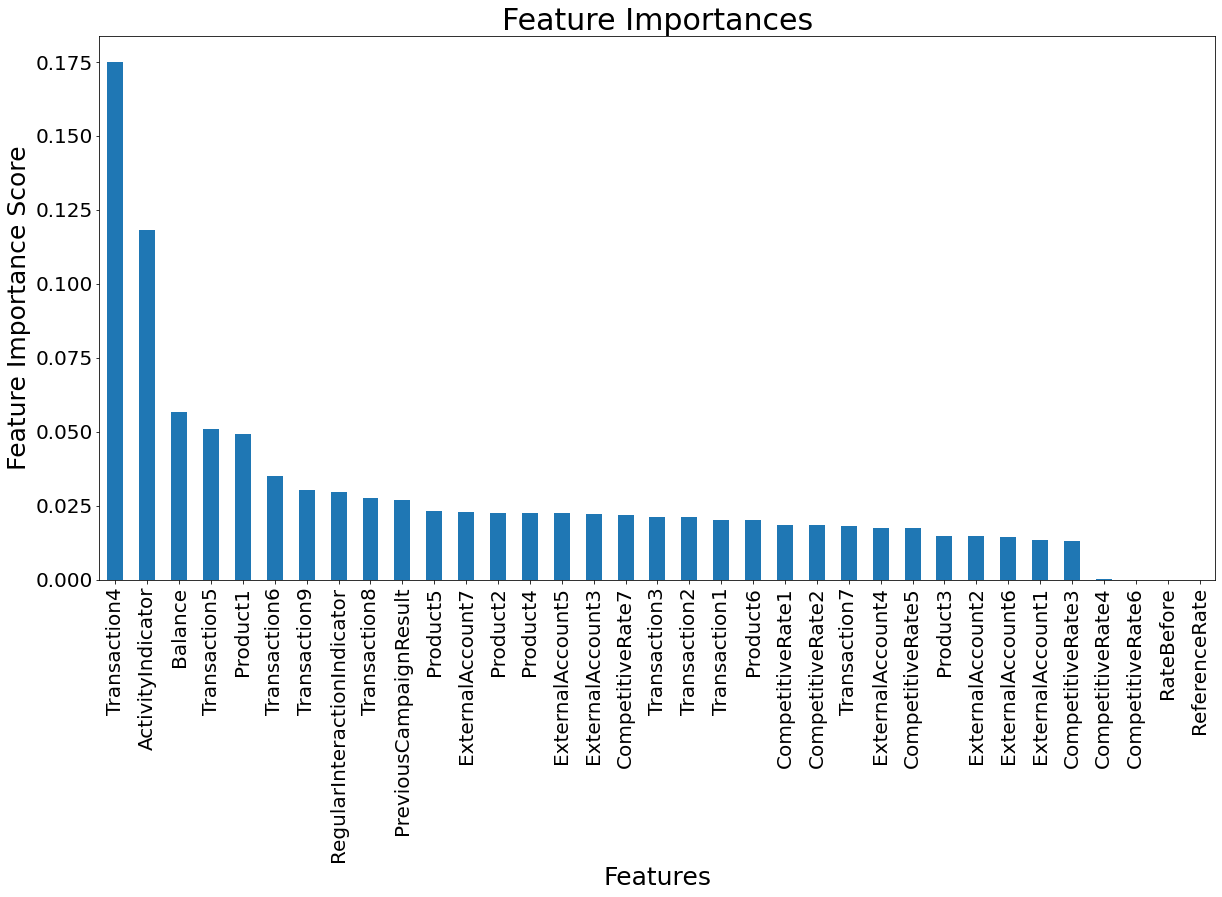

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [14]:
modelfit(xgb_clf_1, df_train, df_test, col_predictors)

## Tune max_depth and min_child_weight

In [15]:
param_test_1 = {
 'max_depth': range(3, 10, 2),
 'min_child_weight': range(1, 6, 2)
}

gs_1 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate = 0.1, 
        n_estimators = 140, 
        max_depth = 5,
        min_child_weight = 1,
        gamma = 0, 
        subsample = 0.8, 
        colsample_bytree = 0.8,
        objective = 'binary:logistic', 
        nthread = 4, 
        scale_pos_weight = 1, 
        seed = 27
    ), 
    param_grid = param_test_1, 
    scoring = 'roc_auc',
    n_jobs = 4, 
    cv = 5
)

gs_1.fit(df_train[col_predictors], df_train[Target])

C:\Users\Mah Lau\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:14:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_method=

In [16]:
gs_1.best_params_, gs_1.best_score_

({'max_depth': 3, 'min_child_weight': 5}, 0.673802463705153)

In [17]:
param_test_2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}

gs_2 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate = 0.1, 
        n_estimators = 140, 
        max_depth = 5,
        min_child_weight = 2, 
        gamma = 0,
        subsample = 0.8, 
        colsample_bytree = 0.8,
        objective = 'binary:logistic', 
        nthread = 4, 
        scale_pos_weight = 1,
        seed = 27
    ),
    param_grid = param_test_2, 
    scoring = 'roc_auc', 
    n_jobs = 4,
    cv = 5
)

gs_2.fit(df_train[col_predictors],df_train[Target])

C:\Users\Mah Lau\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:20:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_method=

In [18]:
gs_2.best_params_, gs_2.best_score_

({'max_depth': 4, 'min_child_weight': 6}, 0.6740262529907212)

## Tune Gamma

In [19]:
param_test_3 = {
 'gamma' : [i/10.0 for i in range(0,5)]
}

In [20]:
gs_3 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate = 0.1, 
        n_estimators = 140, 
        max_depth = 4,
        min_child_weight = 6, 
        gamma = 0, 
        subsample = 0.8, 
        colsample_bytree = 0.8,
        objective = 'binary:logistic', 
        nthread = 4, 
        scale_pos_weight = 1,
        seed = 27
    ), 
    
    param_grid = param_test_3, 
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 5
)

gs_3.fit(df_train[col_predictors], df_train[Target])

C:\Users\Mah Lau\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_method=

In [21]:
gs_3.best_params_, gs_3.best_score_

({'gamma': 0.3}, 0.6741381790228578)

## Using new max depth, min child weight, gamma values

In [22]:
xgb_clf_2 = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 1000,
    max_depth = 4,
    min_child_weight = 6,
    gamma = 0.3,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    nthread = 4,
    scale_pos_weight = 1,
    seed = 27
)


Model Report
Accuracy : 0.6412
AUC Score (Train) : 0.692884
Precision Score : 0.650002
Recall Score : 0.610943
F1 Score : 0.629867


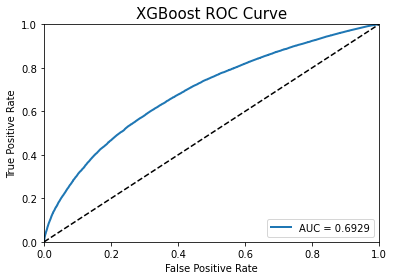

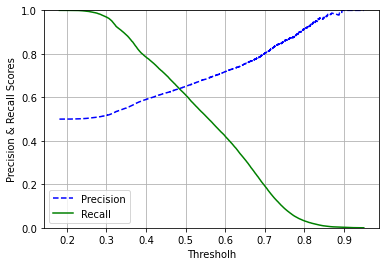

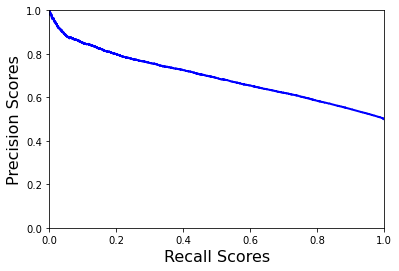

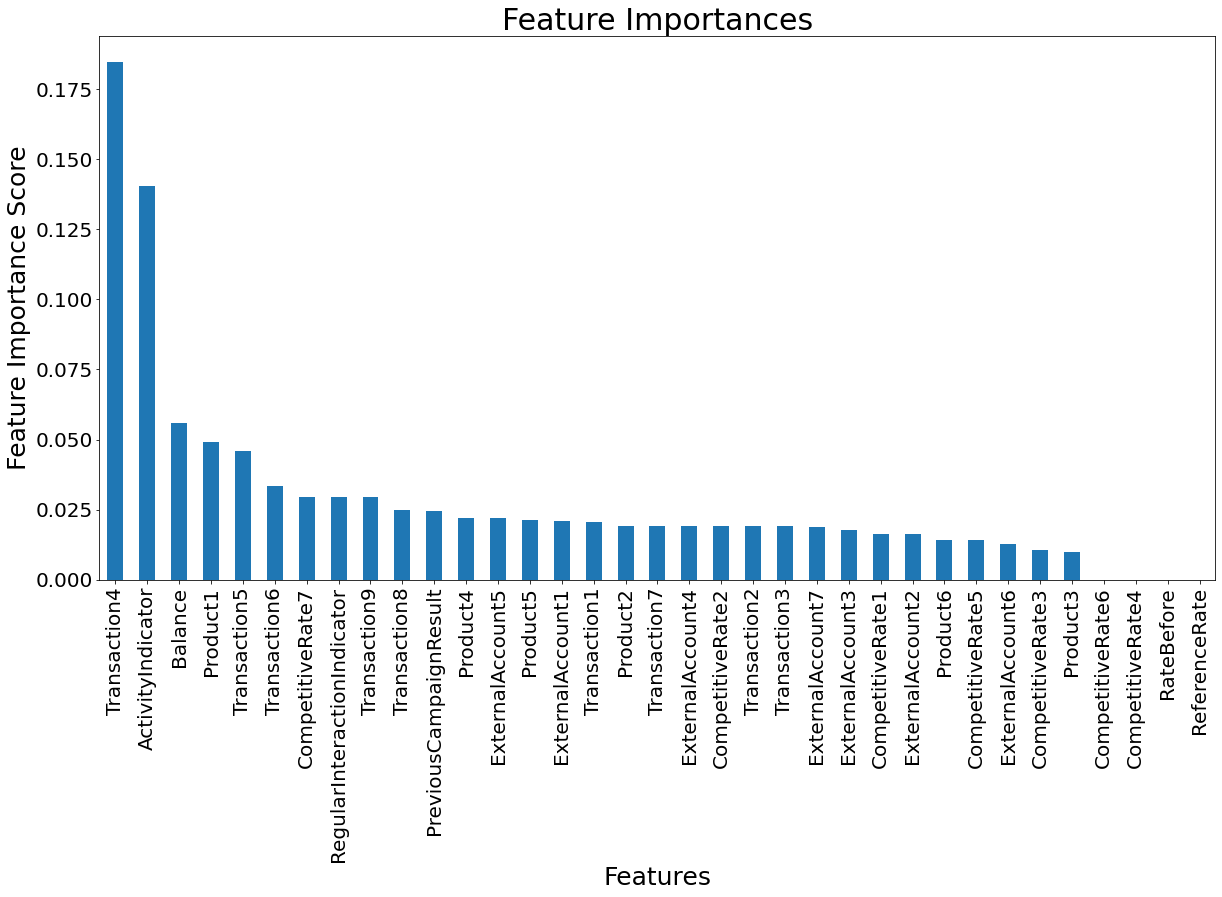

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [23]:
modelfit(xgb_clf_2, df_train, df_test, col_predictors)

## Tune subsample and colsample_bytree
* 0.1 intervals

In [24]:
param_test_4 = {
 'subsample' : [i / 10.0 for i in range(6,10)],
 'colsample_bytree' : [i / 10.0 for i in range(6,10)]
}

gs_4 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate = 0.1, 
        n_estimators = 177,
        max_depth = 4,
        min_child_weight = 6, 
        gamma = 0, 
        subsample = 0.8, 
        colsample_bytree = 0.8,
        objective = 'binary:logistic', 
        nthread = 4, 
        scale_pos_weight = 1,
        seed = 27
    ), 
    param_grid = param_test_4, 
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 5
)

gs_4.fit(df_train[col_predictors], df_train[Target])

C:\Users\Mah Lau\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_method=

In [25]:
gs_4.best_params_, gs_4.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.9}, 0.6740857007757658)

## Using 0.05 intervals for subsample and colsample_bytree

In [26]:
param_test_5 = {
 'subsample': [i/100.0 for i in range(75,90,5)],
 'colsample_bytree': [i/100.0 for i in range(75,90,5)]
}

gs_5 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate = 0.1, 
        n_estimators = 177, 
        max_depth = 4,
        min_child_weight = 6, 
        gamma = 0, 
        subsample = 0.8, 
        colsample_bytree = 0.8,
        objective = 'binary:logistic', 
        nthread = 4, 
        scale_pos_weight = 1,
        seed = 27
    ), 
    param_grid = param_test_5, 
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 5
)

gs_5.fit(df_train[col_predictors], df_train[Target])

C:\Users\Mah Lau\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_method=

In [27]:
gs_5.best_params_, gs_5.best_score_

({'colsample_bytree': 0.85, 'subsample': 0.85}, 0.6739249830162086)

## Tune Regularization Parameters

In [28]:
param_test_6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gs_6 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate = 0.1, 
        n_estimators = 177, 
        max_depth = 4,
        min_child_weight = 6, 
        gamma = 0.1, 
        subsample = 0.8, 
        colsample_bytree = 0.8,
        objective = 'binary:logistic', 
        nthread = 4, 
        scale_pos_weight = 1,
        seed = 27
    ), 
    param_grid = param_test_6, 
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 5
)

gs_6.fit(df_train[col_predictors],df_train[Target])

C:\Users\Mah Lau\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:38:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0.1,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_metho

In [29]:
gs_6.best_params_, gs_6.best_score_

({'reg_alpha': 0.1}, 0.6741165226642958)

In [30]:
param_test_7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gs_7 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate = 0.1, 
        n_estimators = 177, 
        max_depth = 4,
        min_child_weight = 6, 
        gamma = 0.1, 
        subsample = 0.8, 
        colsample_bytree = 0.8,
        objective = 'binary:logistic', 
        nthread = 4, 
        scale_pos_weight = 1,
        seed = 27
    ), 
    param_grid = param_test_7, 
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 5
)

gs_7.fit(df_train[col_predictors], df_train[Target])

C:\Users\Mah Lau\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:39:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0.1,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_metho

In [31]:
gs_7.best_params_, gs_7.best_score_

({'reg_alpha': 0.001}, 0.6740631698661663)

## Use new values for params
* max_depth = 4
* min_child_weight = 6 
* gamma = 0.3
* subsample = 0.85
* colsample_bytree = 0.85
* reg_alpha = 0.001

In [32]:
xgb_clf_3 = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 1000,
    max_depth = 4,
    min_child_weight = 6,
    gamma = 0.3,
    subsample = 0.85,
    colsample_bytree = 0.85,
    reg_alpha = 0.001,
    objective = 'binary:logistic',
    nthread = 4,
    scale_pos_weight = 1,
    seed = 27
)


Model Report
Accuracy : 0.6395
AUC Score (Train) : 0.690483
Precision Score : 0.648095
Recall Score : 0.609880
F1 Score : 0.628407


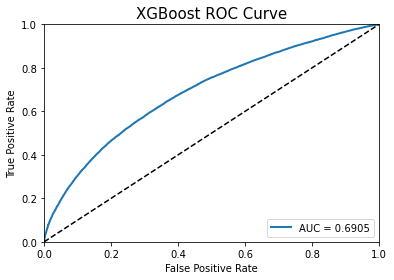

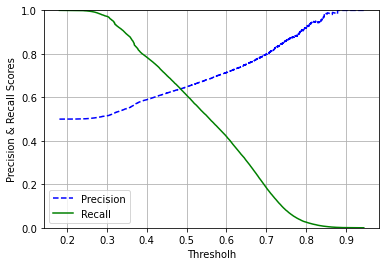

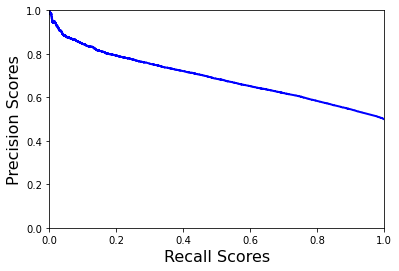

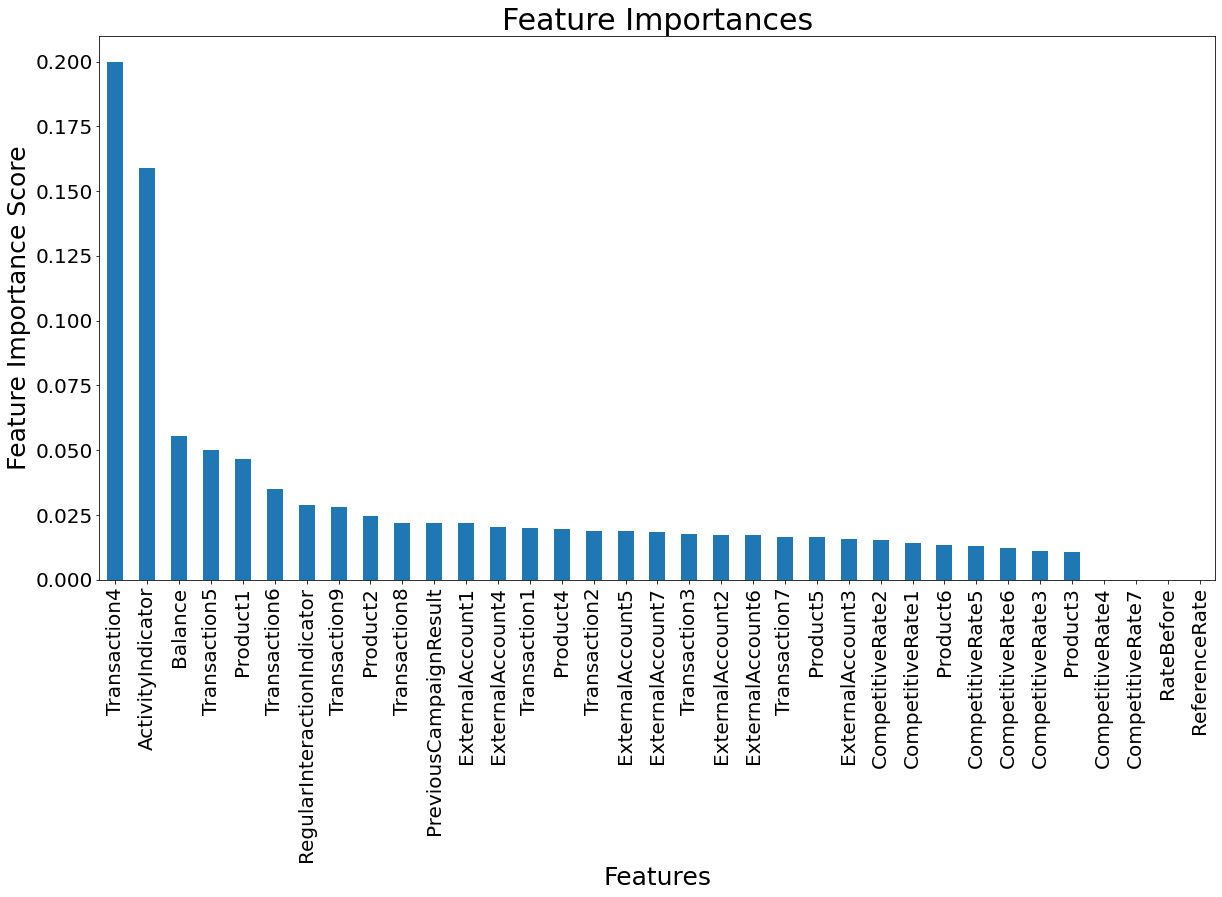

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [33]:
modelfit(xgb_clf_3, df_train, df_test, col_predictors)

## Reduce Learning Rate
 * increase number of tree / estimators

In [34]:
xgb_clf_4 = XGBClassifier(
    learning_rate = 0.01,
    n_estimators = 4000,
    max_depth = 4,
    min_child_weight = 6,
    gamma = 0.3,
    subsample = 0.85,
    colsample_bytree = 0.85,
    reg_alpha = 0.001,
    objective = 'binary:logistic',
    nthread = 4,
    scale_pos_weight = 1,
    seed = 27
)

C:\Users\Mah Lau\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Model Report
Accuracy : 0.6427
AUC Score (Train) : 0.695277
Precision Score : 0.652525
Recall Score : 0.609723
F1 Score : 0.630398


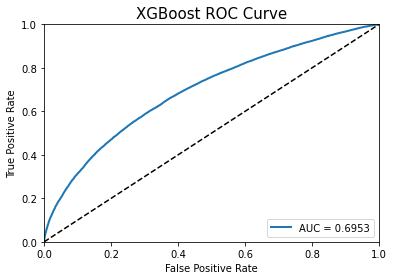

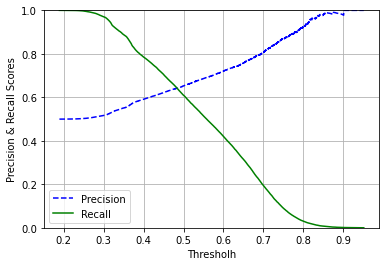

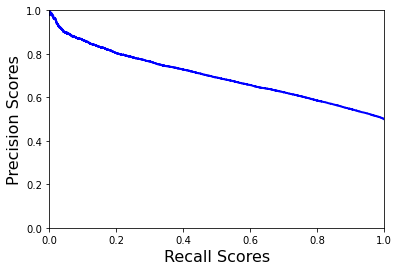

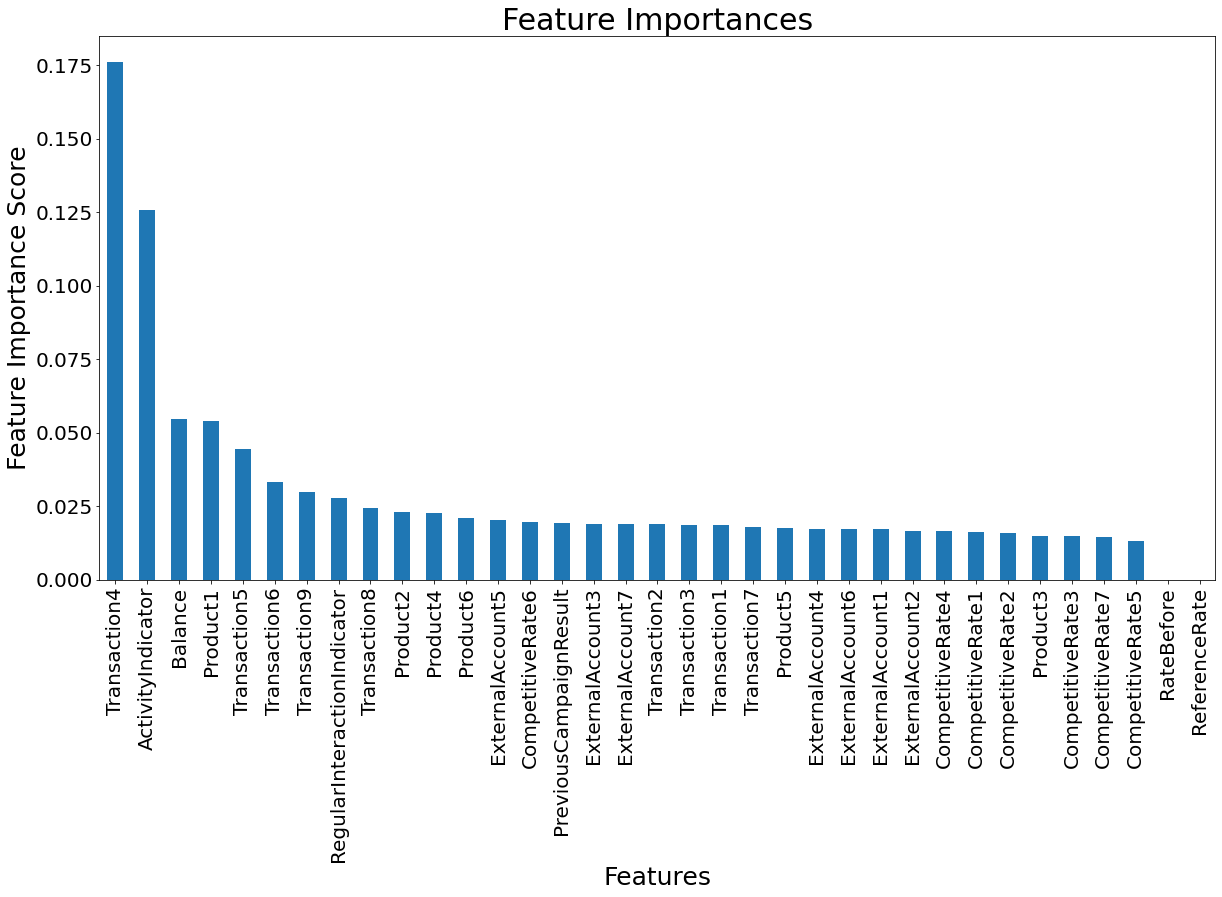

In [36]:
dtest_pred = modelfit(xgb_clf_4, df_train, df_test, col_predictors)

# submission

In [37]:
submission_xgb = pd.DataFrame({
    'Customer_id' : df_test['Customer_id'],
    'Target' : dtest_pred
})

In [38]:
submission_xgb['Target'].value_counts()

0    759
1    721
Name: Target, dtype: int64

In [39]:
submission_xgb.to_csv('submission.csv', index = False)